<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/KC_Indicator_for_Trading_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

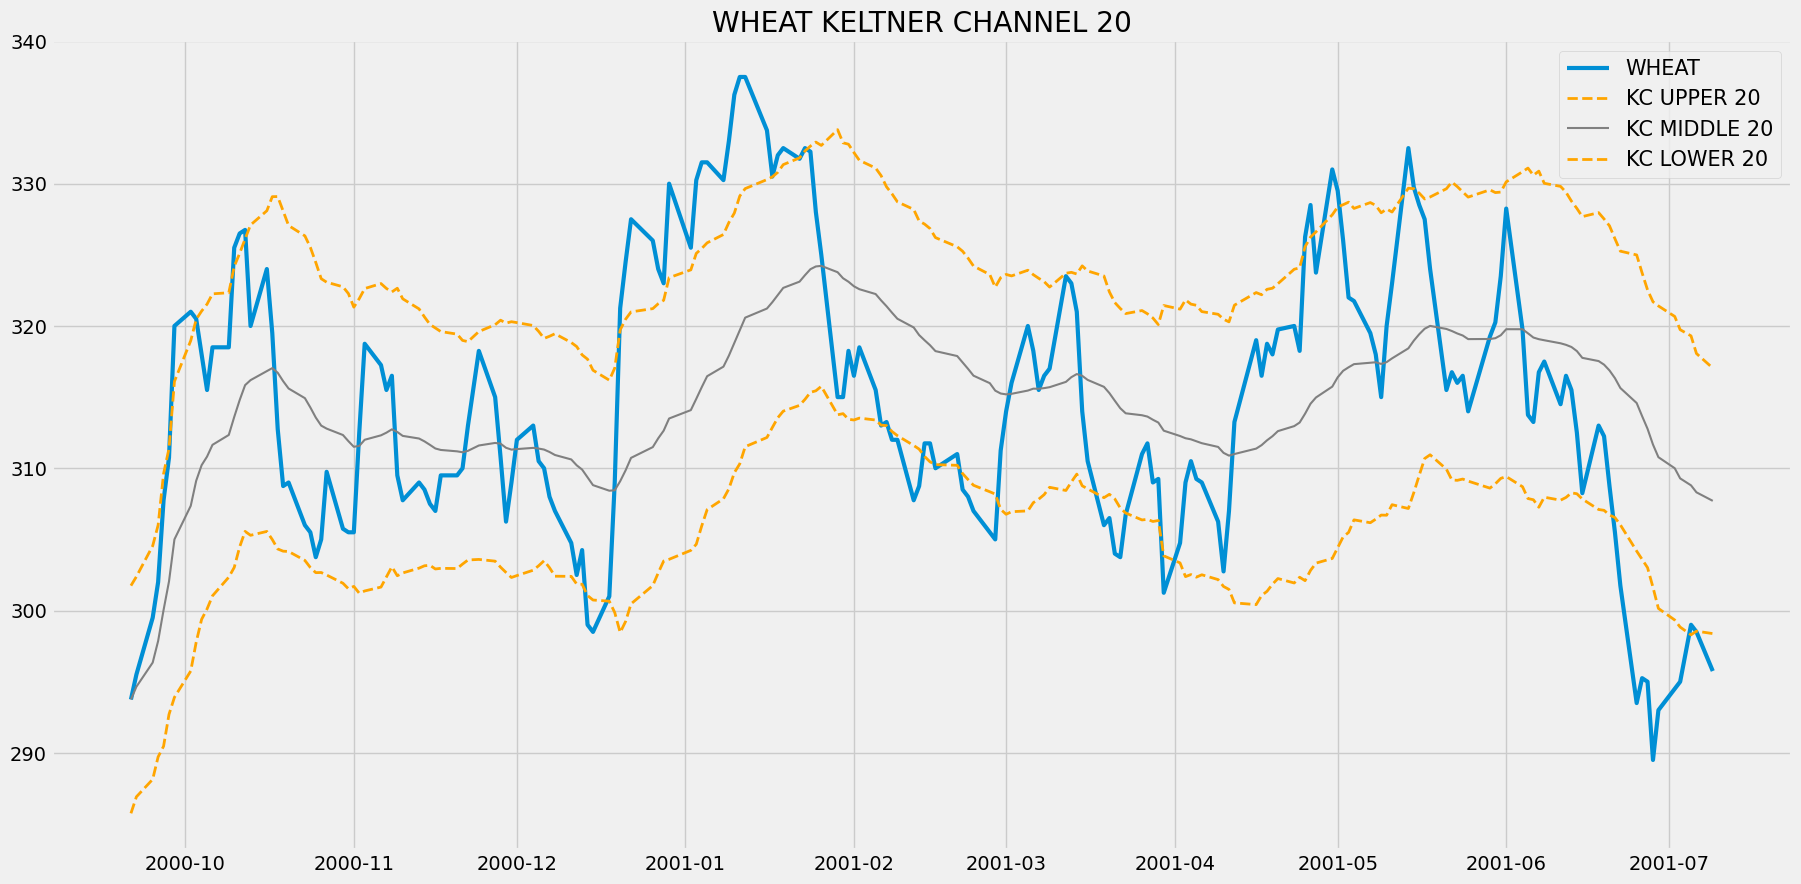

BUY:  334 Shares are bought at $299.0 on 2000-12-14
SELL:  334 Shares are bought at $321.25 on 2000-12-20
BUY:  343 Shares are bought at $313.0 on 2001-02-06
SELL:  343 Shares are bought at $326.25 on 2001-04-25
BUY:  366 Shares are bought at $305.5 on 2001-06-21
SELL:  366 Shares are bought at $293.0 on 2002-03-27
BUY:  391 Shares are bought at $274.0 on 2002-04-26
SELL:  391 Shares are bought at $293.0 on 2002-05-31
BUY:  267 Shares are bought at $429.25 on 2002-11-08
SELL:  267 Shares are bought at $361.0 on 2003-05-09
BUY:  309 Shares are bought at $312.0 on 2003-06-16
SELL:  309 Shares are bought at $333.0 on 2003-07-23
BUY:  311 Shares are bought at $331.5 on 2003-09-18
SELL:  311 Shares are bought at $362.25 on 2003-10-01
BUY:  305 Shares are bought at $369.0 on 2004-03-08
SELL:  305 Shares are bought at $403.0 on 2004-03-18
BUY:  329 Shares are bought at $373.5 on 2004-06-15
SELL:  329 Shares are bought at $361.5 on 2004-09-15
BUY:  362 Shares are bought at $328.75 on 2005-01-0

In [1]:
# IMPORTING PACKAGES

import requests
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored as cl
import math

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

# EXTRACTING HISTORICAL DATA

#api_key = 'YOUR API KEY'
api_key = '437d9fc7279175d9df13676245b72972'

def extract_historical(api_key, start, symbol):
    json = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start}&apikey={api_key}').json()
    df = pd.DataFrame(json['historical']).set_index('date')
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1]
    return df

wheat_hist = extract_historical(api_key, '2000-01-01', 'KEUSX')
wheat_hist

# KELTNER CHANNEL CALCULATION

def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()

    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr

    return kc_middle, kc_upper, kc_lower

wheat_hist = wheat_hist.iloc[:,:5]
wheat_hist['kc_middle'], wheat_hist['kc_upper'], wheat_hist['kc_lower'] = get_kc(wheat_hist['high'], wheat_hist['low'], wheat_hist['close'], 20, 2, 10)
wheat_hist

# KELTNER CHANNEL PLOT

plt.plot(wheat_hist[:200]['close'], linewidth = 3, label = 'WHEAT')
plt.plot(wheat_hist[:200]['kc_upper'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(wheat_hist[:200]['kc_middle'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(wheat_hist[:200]['kc_lower'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')

plt.legend(fontsize = 15)
plt.title('WHEAT KELTNER CHANNEL 20')

plt.show()

# BACKTESTING THE STRATEGY

def implement_strategy(wheat_hist, investment, symbol):

    in_position = False
    equity = investment

    for i in range(1, len(wheat_hist)):
        if wheat_hist['close'][i-1] > wheat_hist['kc_lower'][i-1] and wheat_hist['close'][i] < wheat_hist['kc_lower'][i] and in_position == False:
            no_of_shares = math.floor(equity/wheat_hist.close[i])
            equity -= (no_of_shares * wheat_hist.close[i])
            in_position = True
            print(cl('BUY: ', color = 'green', attrs = ['bold']), f'{no_of_shares} Shares are bought at ${wheat_hist.close[i]} on {str(wheat_hist.index[i])[:10]}')
        elif wheat_hist['close'][i-1] < wheat_hist['kc_upper'][i-1] and wheat_hist['close'][i] > wheat_hist['kc_upper'][i] and in_position == True:
            equity += (no_of_shares * wheat_hist.close[i])
            in_position = False
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are bought at ${wheat_hist.close[i]} on {str(wheat_hist.index[i])[:10]}')
    if in_position == True:
        equity += (no_of_shares * wheat_hist.close[i])
        print(cl(f'\nClosing position at {wheat_hist.close[i]} on {str(wheat_hist.index[i])[:10]}', attrs = ['bold']))
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)

    print('')
    print(cl(f'{symbol} BACKTESTING RESULTS:', attrs = ['bold']))
    print(cl(f'EARNING: ${earning} ; ROI: {roi}%', attrs = ['bold']))

implement_strategy(wheat_hist, 100000, 'KEUSX')

# BUY/HOLD STRATEGY RETURNS

bh_roi = round(list(wheat_hist['close'].pct_change().cumsum())[-1],4)*100
print(cl(f'BUY/HOLD STRATEGY ROI: {round(bh_roi,2)}%', attrs = ['bold']))

def implement_kc_strategy(symbol):

    # EXTRACTING HISTORICAL DATA

    hist = extract_historical(api_key, '2000-01-01', symbol)

    # KELTNER CHANNEL CALCULATION

    hist = hist.iloc[:,:5]
    hist['kc_middle'], hist['kc_upper'], hist['kc_lower'] = get_kc(hist['high'], hist['low'], hist['close'], 20, 2, 10)

    # BACKTESTING

    implement_strategy(hist, 100000, symbol)

implement_kc_strategy('ZCUSX')
implement_kc_strategy('ZSUSX')
implement_kc_strategy('KCUSX')
implement_kc_strategy('SBUSX')

def print_latest_signal(df):
    # Assuming the DataFrame is ordered with the most recent data last.
    latest_row = df.iloc[-1]
    previous_row = df.iloc[-2]

    print("\nLatest Signal:")
    if previous_row['close'] > previous_row['kc_lower'] and latest_row['close'] < latest_row['kc_lower']:
        print("BUY signal - the closing price dropped below the lower KC boundary.")
    elif previous_row['close'] < previous_row['kc_upper'] and latest_row['close'] > latest_row['kc_upper']:
        print("SELL signal - the closing price rose above the upper KC boundary.")
    else:
        print("NO signal - the price is within the KC boundaries.")

# Example usage at the end of your script
print_latest_signal(wheat_hist)



this code was give in the article https://medium.datadriveninvestor.com/forget-stocks-this-commodity-algo-trading-strategy-made-260-returns-1c13a14c94c6
The API come from the platform https://site.financialmodelingprep.com/developer/docs#commodities-daily-commodities?utm_source=medium&utm_medium=blog&utm_campaign=Nikhil12